In [2]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
from random import randint
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score, log_loss
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
%matplotlib inline

trd = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')
df = pd.concat([trd, tsd], ignore_index=True, sort  = False)

In [ ]:
#Разведочный анализ
print('Число строк и колонок в таблице: ', df.shape)
print('Типы данных в колонках:', '\n', df.dtypes)

df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print('Колонки с числовыми значениями:', '\n', numeric_cols)

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print('Колонки с объектными значениями:', '\n', non_numeric_cols)

print('Пропущенные значения в колонках:', '\n', df.isnull().sum())

In [ ]:
#Построение гистограмм для всех колонок с числовыми значениями
def show_hist(df):
    for col in df.columns:
        if col in df.select_dtypes(include=[np.number]):
            df[col].iplot(kind='hist', title=col)
        else:
            print(col, "не числовая колонка")
            
show_hist(df)

<AxesSubplot:>

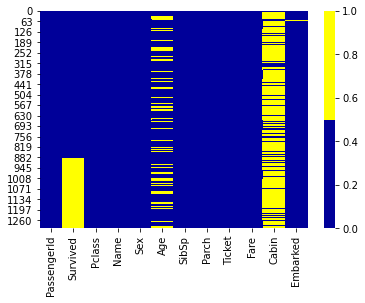

In [12]:
#Тепловая карта пропущенных значений
sns.heatmap(df[df.columns].isnull(), cmap=sns.color_palette(['#000099', '#ffff00'])) #желтый - пропущенные данные

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [ ]:
df.isnull().sum()

In [ ]:
trd = trd.dropna()

In [ ]:
trd.isnull().sum()

In [ ]:
df['Age'] = pd.to_numeric(df['Age'], downcast='integer')

In [ ]:
df['Age']

In [ ]:
df.groupby('Sex').Age.median() 

In [ ]:
df['Age'] = df.groupby(['Pclass']).Age.apply(lambda x: x.fillna(randint(2,45)))

In [ ]:
df['Age'].iplot(kind='hist', 
                xTitle='Возраст пассажиров',
                yTitle='Число людей в возрастной группе', 
                title='Возраст пассажиров Титаника')

In [10]:
show_hist(df)

Name не числовая колонка
Sex не числовая колонка


Ticket не числовая колонка


Cabin не числовая колонка
Embarked не числовая колонка


In [ ]:
alive = df[df['Survived']==1]['Age']
dead = df[df['Survived']==0]['Age']

In [ ]:
percent = pd.DataFrame({'alive':alive, "dead":dead})

In [ ]:
percent.info()

In [ ]:
percent.iplot(
    kind='hist',
    barmode='overlay',
    xTitle='Time of Day',
    yTitle='(%) of Articles',
    title='Time Started and Time Published')

In [ ]:
y = df['Age'].dropna().unique()
x = df['Age'].value_counts()

In [ ]:
df.isna().sum()

In [ ]:
df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)    

In [ ]:
df['Age'] = pd.cut(df.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80])

In [ ]:
fig_sex = (trd.Sex.value_counts(normalize = True) * 100).plot.bar()
male_pr = round((trd[trd.Sex == 'male'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
female_pr = round((trd[trd.Sex == 'female'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
sex_perc_df = pd.DataFrame(
    { "Percentage Survived":{"male": male_pr,"female": female_pr},  "Percentage Not Survived":{"male": 100-male_pr,"female": 100-female_pr}})
sex_perc_df.plot.barh().set_title("Percentage of male and female survived and Deceased")
fig_sex

In [ ]:
survived = df[df['Survived']==1][x].value_counts()
dead = df[df['Survived']==0][x].value_counts()

In [ ]:
def fig_chart(feature, df):
    describe = df['feature'].unique()
    update_sur = {}
    update_dead = {}
    for x in describe:
        
        x_pr = round((df[df.feature == x].Survived == 1).value_counts()[1]/len(df.feature) * 100, 2)
        update_sur[x] = x_pr
        update_dead[x] = 100-x_pr      
    
    df = pd.DataFrame({"Survived, %": update_sur, "Not Survived, %": update_dead})
    df.plot.barh().set_title("Percentage of survived and Deceased")

In [ ]:
fig_chart(Sex, df)

In [ ]:
describe = df['feature'].unique()
update_sur = {}
update_dead = {}
for x in describe:
    x_pr = round((df[df.feature == x].Survived == 1).value_counts()[1]/len(df.feature) * 100, 2)
    update_sur[x] = x_pr
    update_dead[x] = 100-x_pr      
    
df = pd.DataFrame({"Survived, %": update_sur, "Not Survived, %": update_dead})
df.plot.barh().set_title("Percentage of survived and Deceased")

In [ ]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

In [ ]:
#Создаем фрейм для предсказания
X_to_be_predicted = tsd.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], axis=1)
X_to_be_predicted['Sex'] = LabelEncoder().fit_transform(X_to_be_predicted['Sex'])

In [ ]:
X_to_be_predicted.shape

In [ ]:
#Подготовка обучающей и тестовых выборок
train_data = df #Выбираем фрейм
train_data = train_data.dropna() #В новом фрейме чистим от пустых строк
y = train_data['Survived'] #Зависимая переменная
X = train_data.drop(['Survived'], axis = 1) #Предикторы
train_data.shape 

In [ ]:
#Расщепление на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,                                                    
                                                    test_size=0.2 # доля объёма тестового множества
                                                   )

In [ ]:
model = RandomForestClassifier(criterion='gini', 
                               n_estimators=300,
                               min_samples_split=10,
                               min_samples_leaf=1,
                               max_depth=3, #Макс число слоев 
                               max_features='auto',
                               oob_score=True,
                               random_state=42,
                               n_jobs=-1,
                               warm_start=False, #использовать результаты предыдущего вызова и нарастить предыдущий лес
                               class_weight=None )

model.fit(X_train, y_train)
result = model.predict(X_to_be_predicted)

print("RF Accuracy: "+repr(round(model.score(X_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(model, X_train, y_train, cv=10)

#Важность вклада предикторов
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

In [ ]:
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic_test_predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)